In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx
from louvain import detect_communities, modularity

In [3]:
# !pip3 install netgraph

In [4]:
# from netgraph import Graph



In [5]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [6]:
def draw_communities(G, node_size=30, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    # with open('data/comm_output.txt', 'w', encoding='utf-8') as file:
    #     file.writelines(str(par) for par in partition)
    print("Num of Comm: ", len(partition))
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")

    # community_to_color = {
    # 0 : 'tab:blue',
    # 1 : 'tab:orange',
    # 2 : 'tab:green',
    # 3 : 'tab:red',
    # 4 : 'tab:yellow',
    # 5 : 'tab:pink',
    # 6 : 'tab:black',
    # 7 : 'tab:purple',
    # 8 : 'tab:magenta',
    # 9 : 'tab:coral',
    # 10 : 'tab:brown',
    # 11 : 'tab:lavender',
    # 12 : 'tab:olive',
    # 13 : 'tab:teal',
    # 14 : 'tab:mustard',
    # 15 : 'tab:rust',
    # 16 : 'tab:silver',
    # }
    # node_color = {node: community_to_color[community_id] for node, community_id in community_map.items()}

    # Graph(G,
    #   node_color=node_color, node_edge_width=0, edge_alpha=0.1,
    #   node_layout='community', node_layout_kwargs=dict(node_to_community=community_map),
    #   edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
    # )

    # plt.show()

    # pos = community_layout(G, community_map)

    # nx.draw(G, pos, node_color=[community_map.get(node) for node in G]); plt.show()



    pos = nx.spring_layout(G, scale=3., k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)

Num of Comm:  4
Modularity for best partition: 0.44490358126721774


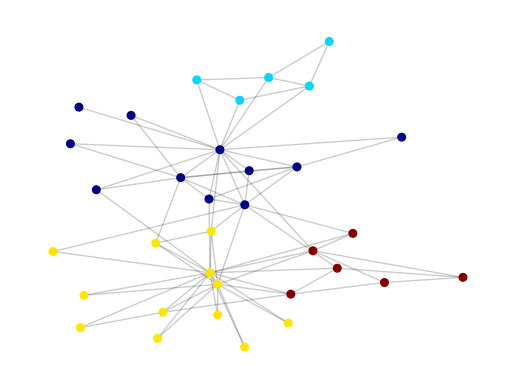

In [7]:
G = nx.karate_club_graph()
draw_communities(G)

In [8]:
import random

number_of_test_nodes = 88234
# Specify the input and output file paths
input_file_path = 'data/facebook_combined.txt'
output_file_path = 'data/com-amazon.ungraph.sample.{}.txt'.format(number_of_test_nodes)

# Function to get number_of_test_nodes random lines from a file
def get_random_lines(file_path, num_lines=number_of_test_nodes):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        random_lines = random.sample(lines, min(num_lines, len(lines)))
    return random_lines

# Function to write lines to a file
def write_lines_to_file(lines, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(lines)

# Get 100 random lines from the input file
random_lines = get_random_lines(input_file_path)

# Write the random lines to the output file
write_lines_to_file(random_lines, output_file_path)

In [9]:
def read_amazone_data(file_name):
    G = nx.Graph()
    with open(file_name, "r") as f:
        for line in f:
            if line[0] == "#":
                continue
            N1, N2 = map(int, line.split())
            G.add_edge(N1, N2)
    return G

In [10]:
caltech_graph = read_amazone_data("data/com-amazon.ungraph.sample.{}.txt".format(number_of_test_nodes))

Num of Comm:  16
Modularity for best partition: 0.834973251139902


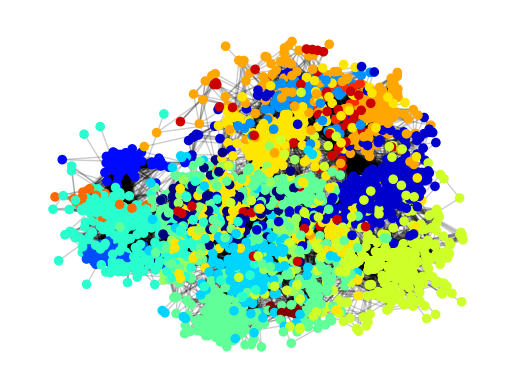

In [11]:
draw_communities(caltech_graph, node_size=35, k=0.12)